torch.Size([512, 1024])


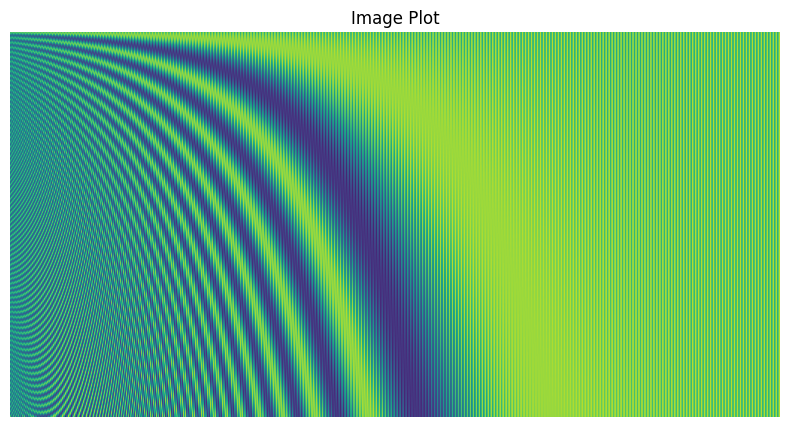

In [5]:
import torch
from typing import Tuple
import matplotlib.pyplot as plt
from torch import nn
# def generate_rotational_matrix(num_pos_feats: int) -> torch.Tensor:
#     """
#     Generate a rotational matrix of size num_pos_feats * num_pos_feats using concepts from information theory.

#     Args:
#     num_pos_feats (int): The size of the matrix (square matrix).

#     Returns:
#     torch.Tensor: A rotational matrix of size (num_pos_feats, num_pos_feats).
#     """
#     # Creating a diagonal matrix with entropy values
#     entropy_matrix = torch.zeros(num_pos_feats, num_pos_feats)
#     for i in range(num_pos_feats):
#         entropy_matrix[i, i] = torch.log2(torch.tensor((num_pos_feats - i)))

#     # Generating a random rotation matrix using Haar measure (uniform distribution over the orthogonal group)
#     rotation_matrix = torch.qr(torch.randn(num_pos_feats, num_pos_feats, dtype=torch.float64))[0]

#     # Multiply entropy matrix with the rotation matrix to incorporate information theory concept
#     rot_entropy_matrix = torch.matmul(rotation_matrix, entropy_matrix)

#     return rot_entropy_matrix



def generate_rotational_matrix(num_pos_feats: int) -> torch.Tensor:
    """
    Generate a rotational matrix for positional embeddings.

    Args:
        num_pos_feats (int): Number of positional features (channels).

    Returns:
        torch.Tensor: Rotational matrix.
    """
    # Initialize the rotational matrix as an identity matrix
    rotation_matrix = torch.eye(num_pos_feats)
    return rotation_matrix

def rotational_sinusoidal_positional_embeddings(
    tensor: torch.Tensor,
    num_pos_feats: int = 1024,
    temperature: float = 10000,
    normalize: bool = False,
    scale: float = None,
) -> torch.Tensor:
    """
    Generate rotational sinusoidal positional embeddings for an input tensor.

    Args:
        tensor (torch.Tensor): Input tensor of any dimensions.
        num_pos_feats (int): Number of positional features (channels) to generate.
        temperature (float): Temperature for scaling the embeddings.
        normalize (bool): Whether to normalize the embeddings.
        scale (float): Scale factor for the embeddings.

    Returns:
        torch.Tensor: Positional embeddings with the same shape as the input tensor.
    """
 
    if scale is None:
        scale = 2 * torch.pi
    
    shape = tensor.shape
    dim_t = torch.arange(num_pos_feats, dtype=torch.float32, device=tensor.device)
    dim_t = temperature ** (2 * (dim_t // 2) / num_pos_feats)

    pos_embeddings = []
    for dim in range(len(shape)):
        pos = torch.arange(shape[dim], dtype=torch.float32, device=tensor.device)
        pos_embed = pos[:, None] / dim_t[None, :]
        pos_embed[:, 0::2] = torch.sin(pos_embed[:, 0::2])
        pos_embed[:, 1::2] = torch.cos(pos_embed[:, 1::2])
        pos_embeddings.append(pos_embed)

    # Reshape each positional embedding to match the input tensor shape
    reshaped_embeddings = []
    for i, embedding in enumerate(pos_embeddings):
        dims = [1] * len(shape)
        dims[i] = shape[i]
        reshaped_embeddings.append(embedding.view(*dims, -1).expand(*shape, -1))

    pos_embeddings = torch.cat(reshaped_embeddings, dim=-1)
    
     # Apply self-attention to the positional embeddings
    attention_weights = torch.softmax(torch.matmul(pos_embeddings, pos_embeddings.transpose(-1, -2)) / torch.sqrt(torch.tensor(num_pos_feats, dtype=torch.float32)), dim=-1)
    pos_embeddings = torch.matmul(attention_weights, pos_embeddings)
    
    # Apply a rotational block
    rotation_matrix = generate_rotational_matrix(pos_embeddings.shape[-1])
    pos_embeddings = torch.matmul(pos_embeddings.view(-1, pos_embeddings.shape[-1]), rotation_matrix)
    pos_embeddings = pos_embeddings.view(*shape, -1)
    
    
    if normalize:
        # Apply square root mean normalization
        pos_embeddings = pos_embeddings / torch.sqrt(torch.mean(pos_embeddings ** 2, dim=-1, keepdim=True))
        pos_embeddings = pos_embeddings * scale

    return pos_embeddings

torch.manual_seed(seed=100)
# Example usage
tensor = torch.randn(512)
pos_embeddings = rotational_sinusoidal_positional_embeddings(tensor, normalize=True)
print(pos_embeddings.shape) 

import matplotlib.pyplot as plt
# Assuming you have a tensor named 'tensor' with shape torch.Size([512, 1024])

# Normalize the tensor values to the range [0, 1]
tensor_normalized =pos_embeddings/ torch.max(tensor)

# Convert the tensor to a numpy array
image_array = tensor_normalized.numpy()

# Plot the image using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(image_array,)
plt.axis('off')
plt.title('Image Plot')
plt.show()




In [3]:
import torch
from typing import Tuple
import matplotlib.pyplot as plt

def rotational_sinusoidal_positional_embeddings(
    tensor: torch.Tensor,
    num_pos_feats: int = 64,
    temperature: float = 10000,
    normalize: bool = False,
    scale: float = None,
) -> torch.Tensor:
    """
    Generate rotational sinusoidal positional embeddings for an input tensor.

    Args:
        tensor (torch.Tensor): Input tensor of any dimensions.
        num_pos_feats (int): Number of positional features (channels) to generate.
        temperature (float): Temperature for scaling the embeddings.
        normalize (bool): Whether to normalize the embeddings.
        scale (float): Scale factor for the embeddings.

    Returns:
        torch.Tensor: Positional embeddings with the same shape as the input tensor.
    """
    if scale is None:
        scale = 2 * torch.pi
    
    shape = tensor.shape
    dim_t = torch.arange(num_pos_feats, dtype=torch.float32, device=tensor.device)
    dim_t = temperature ** (2 * (dim_t // 2) / num_pos_feats)

    pos_embeddings = []
    for dim in range(len(shape)):
        pos = torch.arange(shape[dim], dtype=torch.float32, device=tensor.device)
        pos_embed = pos[:, None] / dim_t[None, :]
        pos_embed[:, 0::2] = torch.sin(pos_embed[:, 0::2])
        pos_embed[:, 1::2] = torch.cos(pos_embed[:, 1::2])
        pos_embeddings.append(pos_embed)

    # Reshape each positional embedding to match the input tensor shape
    reshaped_embeddings = []
    for i, embedding in enumerate(pos_embeddings):
        dims = [1] * len(shape)
        dims[i] = shape[i]
        reshaped_embeddings.append(embedding.view(*dims, -1).expand(*shape, -1))

    pos_embeddings = torch.cat(reshaped_embeddings, dim=-1)

    if normalize:
        # Apply square root mean normalization
        pos_embeddings = pos_embeddings / torch.sqrt(torch.mean(pos_embeddings ** 2, dim=-1, keepdim=True))
        pos_embeddings = pos_embeddings * scale

    return pos_embeddings

# Example usage
tensor = torch.randn(3, 224, 224)
pos_embeddings = rotational_sinusoidal_positional_embeddings(tensor, normalize=True)
print(pos_embeddings.shape)  # Output: torch.Size([3, 224, 224, 192])




torch.Size([3, 224, 224, 192])


torch.Size([1, 100, 512])


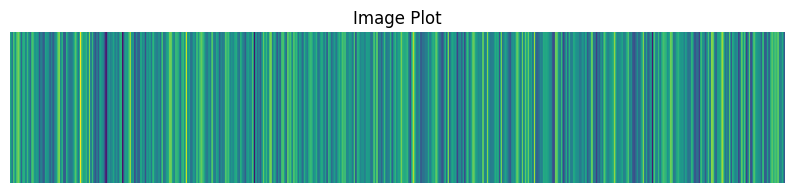

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional

class SelfAttention(nn.Module):
    def __init__(self, embed_size: int, heads: int):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(
        self,
        values: torch.Tensor,
        keys: torch.Tensor,
        queries: torch.Tensor,
        mask: Optional[torch.Tensor],
    ) -> torch.Tensor:
        N = queries.shape[0]  # number of queries
        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # Einsum does matrix multiplication for query*keys for each training example
        # with every other keys across the sequence
        attention = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            attention = attention.masked_fill(mask == 0, float("-1e20"))

        attention = F.softmax(attention / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhqk,nvhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

# Example usage:
batch_size = 1
seq_length = 100
embed_size = 512
heads = 8
model = SelfAttention(embed_size=embed_size, heads=heads)
x = torch.rand((batch_size, seq_length, embed_size))
mask = None  # Replace with actual mask if needed
output = model(x, x, x, mask)
print(output.shape)  # Should be (batch_size, seq_length, embed_size)
# Assuming you have a tensor named 'tensor' with shape torch.Size([512, 1024])
tensor=torch.rand(batch_size, seq_length, embed_size)
# Normalize the tensor values to the range [0, 1]
tensor_normalized =output/ torch.max(tensor)

# Convert the tensor to a numpy array
image_array = tensor_normalized[0].detach().numpy()
import matplotlib.pyplot as plt
# Plot the image using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(image_array,)
plt.axis('off')
plt.title('Image Plot')
plt.show()


torch.Size([1, 100, 512])


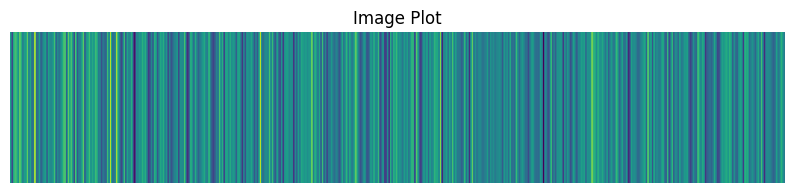

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Optional

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size: int, heads: int):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(
        self,
        queries: torch.Tensor,
        keys: torch.Tensor,
        values: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        N, query_len, _ = queries.shape
        key_len, value_len = keys.shape[1], values.shape[1]

        # Split the embedding into self.heads different pieces
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        values = values.reshape(N, value_len, self.heads, self.head_dim)

        queries = self.queries(queries)
        keys = self.keys(keys)
        values = self.values(values)

        # Einsum does matrix multiplication for query*keys for each training example
        # with every other keys across the sequence
        attention = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            attention = attention.masked_fill(mask == 0, float("-1e20"))

        attention = F.softmax(attention / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhqk,nvhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

# Example usage:
batch_size = 1
seq_length = 100
embed_size = 512
heads = 8
model = MultiHeadAttention(embed_size=embed_size, heads=heads)
x = torch.rand((batch_size, seq_length, embed_size))
mask = None  # Replace with actual mask if needed
output = model(x, x, x, mask)
print(output.shape)  # Should be (batch_size, seq_length, embed_size)
tensor=torch.rand(batch_size, seq_length, embed_size)
# Normalize the tensor values to the range [0, 1]
tensor_normalized =output/ torch.max(tensor)

# Convert the tensor to a numpy array
image_array = tensor_normalized[0].detach().numpy()
import matplotlib.pyplot as plt
# Plot the image using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(image_array,)
plt.axis('off')
plt.title('Image Plot')
plt.show()


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Union


class HierarchicalMixtureOfExperts(nn.Module):
    def __init__(self,
                 input_dim: int,
                 expert_dim: int,
                 num_experts: int,
                 num_routing_layers: int,
                 hidden_dim: int = 128,
                 dropout: float = 0.1,
                 routing_dropout: float = 0.1,
                 device: Union[str, torch.device] = None) -> None:
        """
        Implement Hierarchical Mixture of Experts (HMoE) model

        Args:
            input_dim: Dimensionality of input data
            expert_dim: Dimensionality of experts' output
            num_experts: Number of experts
            num_routing_layers: Number of routing layers
            hidden_dim: Hidden dimension of routing layers
            dropout: Dropout probability
            routing_dropout: Routing dropout probability
            device: Device on which to run the model
        """
        super().__init__()

        self.input_dim = input_dim
        self.expert_dim = expert_dim
        self.num_experts = num_experts
        self.num_routing_layers = num_routing_layers
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.routing_dropout = routing_dropout
        self.device = device

        # Define experts
        self.experts = nn.ModuleList([
            nn.Linear(input_dim, expert_dim) for _ in range(num_experts)
        ])

        # Define routing layers
        self.routing_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, num_experts)
            ) for _ in range(num_routing_layers)
        ])

        # Define gating network
        self.gating_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_experts)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model

        Args:
            x: Input data

        Returns:
            Output of the model
        """

        # Apply routing layers
        for routing_layer in self.routing_layers:
            routing_logits = routing_layer(x)
            routing_probs = F.softmax(routing_logits, dim=-1)
            x = F.dropout(routing_probs, p=self.routing_dropout, training=self.training) * x.unsqueeze(2)

        # Apply gating network
        gating_logits = self.gating_network(x)
        gating_probs = F.softmax(gating_logits, dim=-1)

        # Apply experts
        expert_outputs = [expert(x) for expert in self.experts]

        # Weighted sum of experts' outputs
        output = torch.einsum('be,ek->bk', gating_probs, torch.stack(expert_outputs, dim=1))

        return output


In [6]:

from typing import List, Tuple, Optional

import torch
from torch import nn
from torch.nn import functional as F

class MultiHeadAttention(nn.Module):
    """
    Multi-head attention mechanism.
    
    Args:
        num_heads: Number of attention heads.
        input_dim: Dimensionality of the input vectors.
        output_dim: Dimensionality of the output vectors.
        dropout: Dropout probability.
    """

    def __init__(self, num_heads: int, input_dim: int, output_dim: int, dropout: float = 0.1):
        super().__init__()

        self.num_heads = num_heads
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout

        # Define the weight matrices for the query, key, and value vectors.
        self.query_weight = nn.Linear(input_dim, num_heads * output_dim)
        self.key_weight = nn.Linear(input_dim, num_heads * output_dim)
        self.value_weight = nn.Linear(input_dim, num_heads * output_dim)

        # Define the output projection matrix.
        self.output_projection = nn.Linear(num_heads * output_dim, output_dim)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Forward pass of the multi-head attention mechanism.
        
        Args:
            query: Query vectors. Shape: (batch_size, query_length, input_dim).
            key: Key vectors. Shape: (batch_size, key_length, input_dim).
            value: Value vectors. Shape: (batch_size, value_length, input_dim).
            mask: Optional mask to prevent attention to certain positions. Shape: (batch_size, query_length, key_length).

        Returns:
            Output vectors. Shape: (batch_size, query_length, output_dim).
        """

        # Project the query, key, and value vectors.
        query = self.query_weight(query)
        key = self.key_weight(key)
        value = self.value_weight(value)

        # Reshape the projected vectors to have shape (batch_size, num_heads, sequence_length, output_dim).
        query = query.view(query.size(0), self.num_heads, -1, self.output_dim)
        key = key.view(key.size(0), self.num_heads, -1, self.output_dim)
        value = value.view(value.size(0), self.num_heads, -1, self.output_dim)

        # Calculate the attention weights.
        attention_weights = torch.matmul(query, key.transpose(-2, -1))
        attention_weights = attention_weights / (self.output_dim ** 0.5)

        # Apply the mask to the attention weights.
        if mask is not None:
            attention_weights = attention_weights.masked_fill(mask == 0, -1e9)

        # Calculate the weighted sum of the value vectors.
        output = torch.matmul(attention_weights, value)

        # Reshape the output back to shape (batch_size, query_length, output_dim).
        output = output.view(output.size(0), -1, self.num_heads * self.output_dim)

        # Project the output to the desired dimensionality.
        output = self.output_projection(output)

        # Apply dropout to the output.
        output = F.dropout(output, p=self.dropout)

        return output
model=MultiHeadAttention(8,512,1024,0.2)
query=torch.rand(10,10,512)
values=torch.rand(10,10,512)
keys=values
output=model(query,values,keys)

output.shape


torch.Size([10, 10, 1024])

In [ ]:
from typing import Tuple

import torch
from torch import nn

class FeedForwardNetwork(nn.Module):
    """
    Feed-forward neural network.
    
    Args:
        input_dim: Dimensionality of the input vectors.
        output_dim: Dimensionality of the output vectors.
        hidden_dim: Dimensionality of the hidden layer.
        dropout: Dropout probability.
    """

    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int, dropout: float = 0.1):
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout

        # Define the layers of the network.
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        # Define the dropout layer.
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the feed-forward neural network.
        
        Args:
            x: Input vectors. Shape: (batch_size, input_dim).

        Returns:
            Output vectors. Shape: (batch_size, output_dim).
        """

        # Pass the input through the first linear layer.
        x = self.fc1(x)

        # Apply the ReLU activation function.
        x = F.relu(x)

        # Apply dropout.
        x = self.dropout(x)

        # Pass the input through the second linear layer.
        x = self.fc2(x)

        return x


In [ ]:
from typing import Tuple

import torch
from torch import nn

class ResidualConnection(nn.Module):
    """
    Residual connection.
    
    Args:
        input_dim: Dimensionality of the input vectors.
        output_dim: Dimensionality of the output vectors.
        dropout: Dropout probability.
    """

    def __init__(self, input_dim: int, output_dim: int, dropout: float = 0.1):
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout

        # Define the layers of the residual connection.
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.fc2 = nn.Linear(output_dim, output_dim)

        # Define the dropout layer.
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the residual connection.
        
        Args:
            x: Input vectors. Shape: (batch_size, input_dim).

        Returns:
            Output vectors. Shape: (batch_size, output_dim).
        """

        # Pass the input through the first linear layer.
        x = self.fc1(x)

        # Apply the ReLU activation function.
        x = F.relu(x)

        # Apply dropout.
        x = self.dropout(x)

        # Pass the input through the second linear layer.
        x = self.fc2(x)

        # Add the input to the output.
        x += x

        return x


In [ ]:
from typing import Tuple

import torch
from torch import nn

class Masking(nn.Module):
    """
    Masking module.
    
    Args:
        input_dim: Dimensionality of the input vectors.
        output_dim: Dimensionality of the output vectors.
        dropout: Dropout probability.
    """

    def __init__(self, input_dim: int, output_dim: int, dropout: float = 0.1):
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout

        # Define the layers of the masking module.
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.fc2 = nn.Linear(output_dim, output_dim)

        # Define the dropout layer.
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the masking module.
        
        Args:
            x: Input vectors. Shape: (batch_size, input_dim).
            mask: Mask. Shape: (batch_size, input_dim).

        Returns:
            Output vectors. Shape: (batch_size, output_dim).
        """

        # Pass the input through the first linear layer.
        x = self.fc1(x)

        # Apply the ReLU activation function.
        x = F.relu(x)

        # Apply dropout.
        x = self.dropout(x)

        # Pass the input through the second linear layer.
        x = self.fc2(x)

        # Apply the mask to the output.
        x = x * mask

        return x


In [ ]:
from typing import Tuple

import torch
from torch import nn

class Encoder(nn.Module):
    """
    Encoder network.
    
    Args:
        input_dim: Dimensionality of the input vectors.
        output_dim: Dimensionality of the output vectors.
        hidden_dim: Dimensionality of the hidden layer.
        num_layers: Number of encoder layers.
        dropout: Dropout probability.
    """

    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int, num_layers: int, dropout: float = 0.1):
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        # Define the layers of the encoder network.
        self.layers = nn.ModuleList([nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)])

        # Define the dropout layer.
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the encoder network.
        
        Args:
            x: Input vectors. Shape: (batch_size, input_dim).

        Returns:
            Output vectors. Shape: (batch_size, output_dim).
        """

        # Pass the input through the encoder layers.
        for layer in self.layers:
            x = self.dropout(F.relu(layer(x)))

        return x
